This notebook is to test the branin hoo function

In [1]:
seed_number = 5678

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import random
random.seed(seed_number)
import copy

In [3]:
x1_range = np.arange(-5.0, 10.0, 0.02)
x2_range = np.arange(0.0, 15.0, 0.02)

x1_range_len = len(x1_range)
x2_range_len = len(x2_range)

In [4]:
const_a = 1.0
const_b = 5.1 / (4.0 * np.power(np.pi, 2))
const_c = 5.0 / np.pi
const_r = 6.0
const_s = 10
const_t = 1.0 / (8.0 * np.pi)

def branin_hoo_first_term(x1):
    
    fx = const_s * (1.0 - const_t) * np.cos(x1) + const_s
    
    return fx

def branin_hoo(x1, x2):
    
    fx = branin_hoo_first_term(x1) + const_a * np.power(x2 - const_b * np.power(x1, 2) + const_c * x1 - const_r, 2)
    
    return fx

Text(0.5,0,'b-hoo')

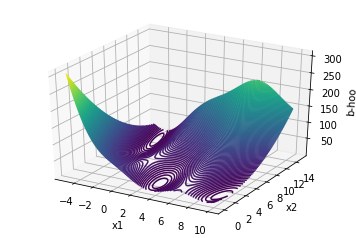

In [5]:
fig = plt.figure()
ax = plt.axes(projection='3d')

X1_mesh, X2_mesh = np.meshgrid(x1_range, x2_range)

Z_mesh = branin_hoo(X1_mesh, X2_mesh)

ax = plt.axes(projection='3d')
ax.contour3D(X1_mesh, X2_mesh, Z_mesh, 200)

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('b-hoo')

# sklearn.gaussian_process

In [22]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import Matern

In [24]:
kernel = C(1.0, (1e-3, 1e3)) * Matern(np.array([2, 2]), (0.1, 10), nu=2.5)

# Training

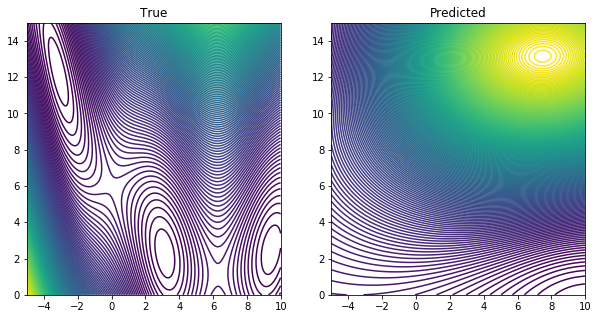

In [25]:
# training
gp_initial = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

train_cnt = 5

x1_train = np.random.choice(x1_range, train_cnt)
x2_train = np.random.choice(x2_range, train_cnt)

x_train = np.stack((x1_train, x2_train)).T
y_train = branin_hoo(x1_train, x2_train)

gp_initial.fit(x_train, y_train)

# Predicting
test_cnt = 5

test = np.random.rand(test_cnt, 2)
test[:, 0] = np.random.choice(x1_range, test_cnt)
test[:, 1] = np.random.choice(x2_range, test_cnt)

y_pred, sigma = gp_initial.predict(test, return_std=True)
y_true = branin_hoo(test[:, 0], test[:, 1])

def plot(X1_mesh, X2_mesh, Z_mesh, gp):
    test = np.stack([np.ravel(X1_mesh), np.ravel(X2_mesh)], axis=1)
    y_pred, _ = gp.predict(test, return_std=True)

    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.contour(X1_mesh, X2_mesh, Z_mesh, 200)
    plt.title('True')
    plt.subplot(122)
    plt.contour(X1_mesh, X2_mesh, y_pred.reshape(X1_mesh.shape), 200)
    plt.title('Predicted')

plot(X1_mesh, X2_mesh, Z_mesh, gp_initial)

# BO prototype

In [26]:
from scipy import optimize

0
      fun: 0
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 3
      nit: 0
   status: 0
  success: True
        x: array([ 8.02, 14.16])
Iteration:  0
x_new: [ 8.02 14.16]
y_pred [142.78609231]
y_new: 167.55209537011672
0
      fun: 0
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 3
      nit: 0
   status: 0
  success: True
        x: array([6.22, 7.24])
Iteration:  1
x_new: [6.22 7.24]
y_pred [42.54264338]
y_new: 57.30091829922621
0
      fun: 0
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 3
      nit: 0
   status: 0
  success: True
        x: array([-4.68,  3.2 ])
Iteration:  2
x_new: [-4.68  3.2 ]
y_pred [6.37164478]
y_new: 180.72057585113632
0
      fun:

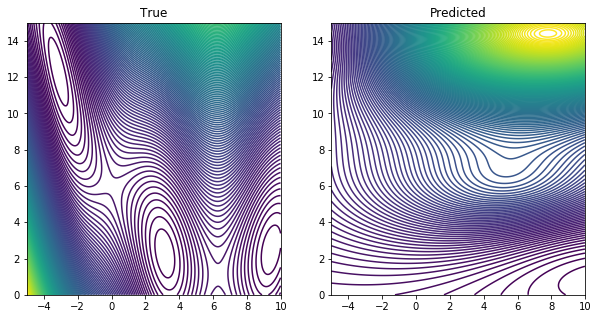

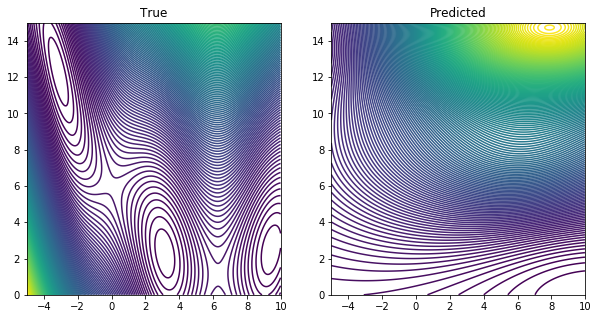

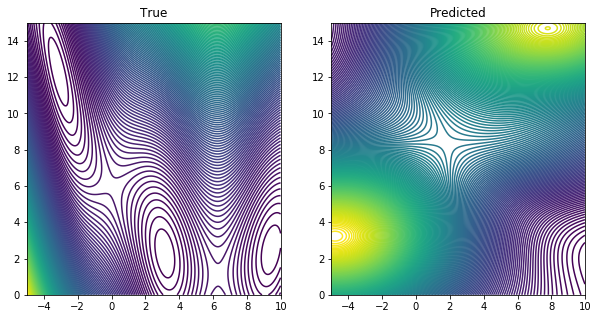

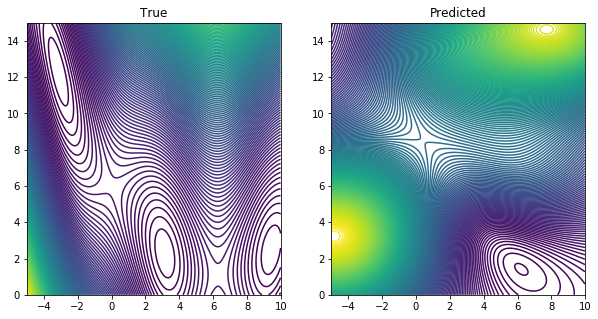

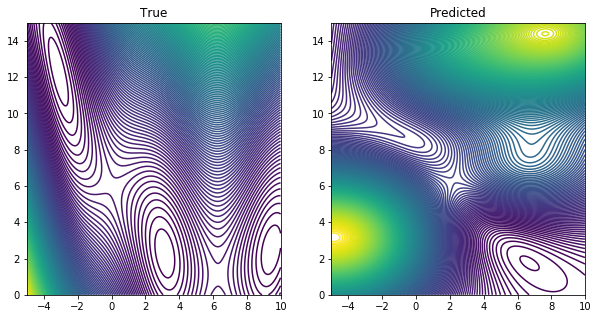

In [30]:
gp_test = copy.deepcopy(gp_initial)

x_test = copy.deepcopy(x_train)
y_test = copy.deepcopy(y_train)

bnds = ((-5.0, 10.0), (0.0, 15.0))

# there should a criterion instead of the number of steps
for i in range(5):
    
    best_value = np.min(y_test)
    
    # EI
    def f(x):
        test = np.stack([np.ravel(x[0]), np.ravel(x[1])], axis=1)
        y_pred = gp_test.predict(test, return_std=False)
        
        # -() is used since we are minimising
        diff = min(y_pred-best_value, 0)
    
        return diff
    
    # random initial point
    x1_new = np.random.choice(x1_range, 1)
    x2_new = np.random.choice(x2_range, 1)
    x_new_st = np.stack((x1_new, x2_new)).T
    
    # finding the next point
    res = optimize.minimize(f, x_new_st, method="L-BFGS-B", bounds=bnds)
    print(res.fun)
    print(res)
    # estimating the real value for the function
    x_new = np.stack((res.x[0], res.x[1])).T
    y_new = branin_hoo(res.x[0], res.x[1])
    
    test = np.stack([np.ravel(res.x[0]), np.ravel(res.x[1])], axis=1)
    y_pr = gp_test.predict(test, return_std=False)
    
    # adding new points to the training
    x_test = np.vstack((x_test, x_new))
    y_test = np.append(y_test, y_new)
    
    print("Iteration: ", i)
    print("x_new:", x_new)
    print("y_pred", y_pr)
    print("y_new:", y_new)
    
    #print("x_test", x_test)
    #print("y_test", y_test)
        
    # refitting GP 
    #   this should use the Cholesky decomposition
    gp_test = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
    gp_test.fit(x_test, y_test)
    
    plot(X1_mesh, X2_mesh, Z_mesh, gp_test)
   

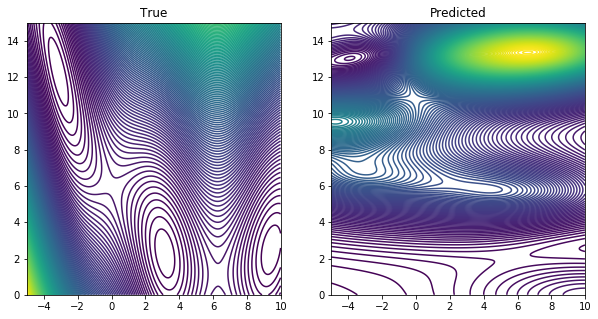

In [28]:
plot(X1_mesh, X2_mesh, Z_mesh, gp_test)

# Iterative

In [12]:
gp_it = copy.deepcopy(gp_initial)

steps = 10

it_x = copy.copy(x_train)
it_y = copy.copy(y_train)

for i in range(steps):
    
    # Finding a new point (at the moment is random, should change to EI or something different)
    x1_new = np.random.choice(x1_range, 1)
    x2_new = np.random.choice(x2_range, 1)
    x_new = np.stack((x1_new, x2_new)).T
     
    #test = np.stack([np.ravel(X1_mesh), np.ravel(X2_mesh)], axis=1)
    #y_pred, _ = gp.predict(test, return_std=True)
    
    y_new = branin_hoo(x1_new, x2_new)
    
    print(i+1, x_new, y_new)
    
    it_x = np.vstack((it_x, x_new))
    
    it_y = np.append(it_y, y_new)
   
    gp_it.fit(it_x, it_y)

1 [[4.32 9.38]] [67.86593964]
2 [[5.26 4.3 ]] [24.59275125]
3 [[-2.24 14.54]] [22.76383708]
4 [[ 6.2  13.82]] [181.41193278]
5 [[-0.32  6.66]] [19.13356497]
6 [[ 0.38 11.58]] [56.93835761]
7 [[ 8.48 14.06]] [154.84410103]
8 [[-2.86  6.56]] [26.26351835]
9 [[5.38 7.84]] [60.34525097]
10 [[1.3  1.28]] [20.80147976]


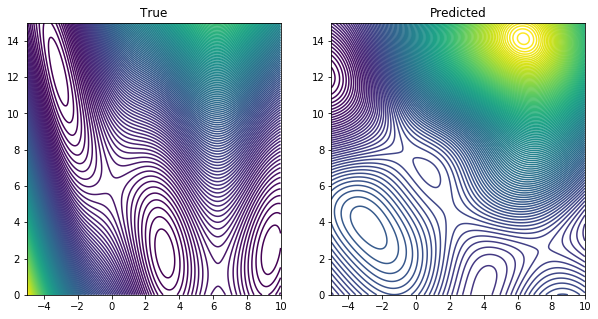

In [13]:
plot(X1_mesh, X2_mesh, Z_mesh, gp_it)